<a href="https://colab.research.google.com/github/PhilBrockman/autobbox/blob/master/Monitor_Model_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 
# Monitor Model Performance
---
(Requires GPU enabled)


This notebook is divided into three sections:

1.   Install Requirements
2.   Configure Environment
3.   Interact with Models

Functions best when you have API access, but fails gracefully to allow the monitoring of just a YOLOv5 model.




# Install Requirements

Run this section and skip down to "Configure Environment"

## Setup

###imports

In [ ]:
# clone YOLOv5 and reset to a specific git checkpoint that has been verified working
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 68211f72c99915a15855f7b99bf5d93f5631330f
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch, time

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
from pathlib import Path
from utils.plots import plot_one_box
import cv2, os, base64, json
from utils.general import check_img_size, non_max_suppression
from utils.datasets import LoadStreams, LoadImages
from utils.general import scale_coords, xyxy2xywh
from utils.torch_utils import select_device
from models.experimental import attempt_load

import PIL.Image
import pandas as pd
!pip install pillow
!pip install colour

from PIL import Image
from io import BytesIO


Cloning into 'yolov5'...
remote: Enumerating objects: 5094, done.
remote: Total 5094 (delta 0), reused 0 (delta 0), pack-reused 5094
Receiving objects: 100% (5094/5094), 7.95 MiB | 35.87 MiB/s, done.
Resolving deltas: 100% (3474/3474), done.
/content/yolov5
HEAD is now at 68211f7 FROM nvcr.io/nvidia/pytorch:20.10-py3 (#1553)
     |████████████████████████████████| 645kB 20.2MB/s 
Setup complete. Using torch 1.7.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


### take photo


#### colab boilerplate

In [ ]:
"""
unfortunately running into bugs running this code in a loop to capture a series of
images. 
"""

# from IPython.display import display, Javascript
# from google.colab.output import eval_js
# from base64 import b64decode

# def take_photo(filename='photo.jpg', quality=0.8, flip=True):
#   js = Javascript('''
#     async function takePhoto(quality) {
#       const div = document.createElement('div');
#       const capture = document.createElement('button');
#       capture.textContent = 'Capture';
#       div.appendChild(capture);

#       const video = document.createElement('video');
#       video.style.display = 'block';
#       const stream = await navigator.mediaDevices.getUserMedia({video: true});

#       document.body.appendChild(div);
#       div.appendChild(video);
#       video.srcObject = stream;
#       await video.play();

#       // Resize the output to fit the video element.
#       google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

#       const canvas = document.createElement('canvas');
#       canvas.width = video.videoWidth;
#       canvas.height = video.videoHeight;
#       canvas.getContext('2d').drawImage(video, 0, 0);
#       stream.getVideoTracks()[0].stop();
#       div.remove();
#       return canvas.toDataURL('image/jpeg', quality);
#     }
#     ''')
#   display(js)
#   data = eval_js('takePhoto({})'.format(quality))
#   binary = b64decode(data.split(',')[1])
#   with open(filename, 'wb') as f:
#     f.write(binary)

#   if flip:
#     im = PIL.Image.open(filename)
#     out = im.transpose(PIL.Image.FLIP_LEFT_RIGHT)
#     out = out.transpose(PIL.Image.FLIP_TOP_BOTTOM)
#     out.save(filename)
#   return filename

'\nunfortunately running into bugs running this code in a loop to capture a series of\nimages. \n'

#### Non-colab method for capturing from webcam

I am using the below code on a local Jupyter notebook to repeatedly capture input from my webcam. Commented for 

In [ ]:
# %matplotlib inline
# import numpy as np
# import cv2, time, base64
# from matplotlib import pyplot as plt
# import PIL

# NUM_PHOTOS = 1
# frames_as_base64 = []

# cap = cv2.VideoCapture(0) # use 0 if you only have front facing camera
# while len(frames_as_base64) < NUM_PHOTOS:
#   time.sleep(1)
#   retval, img = cap.read()
#   #FAILS in google colab
#   cv2.imwrite("filenameee.jpg", img)
#   with open("filename.jpg", "rb") as image_file:
#     encoded_string = base64.b64encode(image_file.read())
#   frames_as_base64.append({"base64": encoded_string.decode(),
#                    "width": im.width,
#                    "height": im.height})
#   plt.imshow(img)
#   plt.show()
# cap.release()


# import json
# filename = "output filename.json"
# with open(filename, "w") as out:
#   json.dump(frames_as_base64, out)

## Class wrapper for detect.py that supporting writing data to disk

In [ ]:
class Detector:
  """A wrapper for training loading saved YOLOv5 weights
  
  requirements:
    GPU enabled"""
  def __init__(self, weight_path, conf_threshold = .4, iou_threshold = .45, imgsz = 416, save_dir="save_dir", save_labeled_img = True, log_bboxes_as_txt = True, ):
    """ Constructor. I pulled the default numeric values above directly from the
    detect.py file. I added the option to save model output to both images and 
    to txt files

    Args:
      weight_path: the path to which the saved weights are stored
      conf_threshold: lower bound on the acceptable level of uncertainty for a 
                      bounding box
      iou_threshold: IoU helps determine how overlapped two shapes are.
      imgsz: resolution of image to process (assumes square)
      save_labeled_img: save a copy of the image with visibile bounding boxing
      log_bboxes_as_txt: create 1 (True) or 0 (False) txt files per bounding box 
    """
    self.weight_path = weight_path
    self.conf_threshold = conf_threshold
    self.iou_threshold = iou_threshold
    self.imgsz = imgsz
    self.device = select_device()
    self.model = attempt_load(self.weight_path, map_location=self.device)  # load FP32 model
    self.names = self.model.module.names if hasattr(self.model, 'module') else self.model.names
    self.imgsz = check_img_size(self.imgsz, s=self.model.stride.max())  # check img_size
    self.half = self.device.type != 'cuda'
    if self.half:
      self.model.half()  # to FP16

    self.save_labeled_img = save_labeled_img
    self.log_bboxes_as_txt = log_bboxes_as_txt
    self.save_dir = save_dir

  def process_image(self, source, save_unscuffed=True):
    """Runs on the model with pre-specified weights an input image. See original
    detect.py for more details

    Args:
      source: A string path to pre-specified weights for the model
      save_unscuffed: create copy of the pre-image

    Reurns:
      A JSON-serializable object encoding bounding box information
    """
    results = []
    img = torch.zeros((1, 3, self.imgsz, self.imgsz), device=self.device)  # init img
    _ = self.model(img.half() if self.half else img) if self.device.type != 'cpu' else None  # run once
    dataset = LoadImages(source, img_size=self.imgsz)
    save_dir = Path(self.save_dir)
    make_dir(save_dir)
    for path, img, im0s, vid_cap in dataset:
      tmp = {}
      tmp["txt"] = []
      img = torch.from_numpy(img).to(self.device)
      img = img.half() if self.half else img.float()  # uint8 to fp16/32
      img /= 255.0  # 0 - 255 to 0.0 - 1.0
      if img.ndimension() == 3:
        img = img.unsqueeze(0)

      pred = self.model(img, augment=False)[0]
      pred = non_max_suppression(pred, self.conf_threshold, self.iou_threshold, agnostic=False)
      
      for i, det in enumerate(pred):
        p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)
        p = Path(p) 
        save_path = str(save_dir / p.name) 
        
        make_dir(str(save_dir / 'labels'))
        txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')
        
        s += '%gx%g ' % img.shape[2:]  # print string
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh

        if len(det):
          det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
          for c in det[:, -1].unique():
              n = (det[:, -1] == c).sum()  # detections per class
              s += f'{n} {self.names[int(c)]}s, '  # add to string
          
          if save_unscuffed:
            tmp["unscuffed"] = f"{save_dir}/unscuffed-{p.name}"
            cv2.imwrite(tmp["unscuffed"], im0)

          for *xyxy, conf, cls in reversed(det):
            if self.log_bboxes_as_txt:  
              xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
              line = (cls, *xywh, conf) if True else (cls, *xywh)  # label format
              i = 0
              run = True
              while run:
                txt_path_ =  f'{txt_path}-{i}.txt'
                if not os.path.exists(txt_path_):
                  open(txt_path_, 'a').close()
                  tmp["txt"].append(txt_path_)
                  run = False
                i += 1
              with open(txt_path_, 'a') as f:
                        f.write(('%g ' * len(line)).rstrip() % line + '\n')
              if True: 
                label = f'{self.names[int(cls)]} {conf:.2f}'
                plot_one_box(xyxy, im0, label=label, color=[0,0,200], line_thickness=5)

            # save image with bboxes drawn on top
            if self.save_labeled_img:
              tmp["labeled"] = f"{save_dir}/labeled-{p.name}"
              cv2.imwrite(tmp["labeled"], im0)

    return tmp

I created these helper functions support the modifcations to detect.py to allow
writing output to disk

In [ ]:
def make_dir(dir):
  """makes a directory provided that the directiory doesn't already exist
  
  Args:
    dir: Directory to create a path towards
  """

  if not os.path.exists(dir):
    os.makedirs(dir)


def touch_file(fpath):
  """`touch`es a file"""
  open(fpath, 'a').close()


def _itername(pre, post):
  """If function terminates, returns the lowest conflict-free file path 
  formatted as '{pre}X{post}' where X is the string representation of a natural
  number
  
  args:
    pre: filename before the counter
    post: filename after the counter

  returns:
    A unique structured filename
  """
  counter = 0
  while True:
    counter += 1
    fpath = f'{pre}{counter}{post}'
    if not os.path.exists(fpath):
      return fpath


## Working with bounding boxes

### data set: preparing bounding boxes for post-processing

In [ ]:
def draw_screen(image):
  """Converts a cv2 imread to base 64

  Args:
    image: resultant value of cv2 imread 
  """
  _, buffer = cv2.imencode('.jpg', image)
  jpg_as_text = base64.b64encode(buffer)
  return jpg_as_text.decode('ascii')

In [ ]:
class Frame:
  """Container for holding an image along with any predictions"""
  def __init__(self, jpg_file, predictions = []):
    """Args:
      jpg_file: string path to a jpeg image
      predictions: array of text files containing bounding box information for 
        this image"""
    self.source = jpg_file
    self.image = cv2.imread(self.source)
    
    #this line make JSON serialization difficult. Yolo(v5) to the consequences!
    self.predictions = [Prediction(x, self) for x in predictions] 

In [ ]:
class Prediction:
  def __init__(self, txt_file=None, parent = None):
    """
    Parses the first line of a txt file. Uses YOLOv5 format:

    CLASS, XCENTER, YCENTER, WIDTH, HEIGHT, CONFIDENCE

    Note that x&y axis have been normed to the interval 0-1. So expect CLASS
    to be an `int` while the remaining values will be of type `float`.

    In the event that a text file is not specified, all values will be set to -1.
    """
    if txt_file:
      self.txt_file = txt_file
      s = open(txt_file, "r").read().split('\n')[0]
      self.original_txt = s
      s = s.split(" ")
    else:
      s = [-1]*6
    self.class_label = s[0]
    self.confidence = s[-1]
    s = [float(x) for x in s[1:5]]
    labels = "xcent ycent width height".split(" ")
    self.bbox = (dict(zip(labels, s))) #zooped
    self.parent = parent

In [ ]:
def preds(i):
  """
  Returns:
    Extracts the array of predictions from model's results
  """
  #legacy compatability
  if "digits" in i.keys():
    preds = i["digits"]["txt"]
  else:
    preds = i["txt"]
  return preds

class DataSet():
  """holds together a series of Frame objects with the eventual goal of exporting
  the data contained therein to a JSON-friendly format"""
  def __init__(self, image_list):
    """Highly tuned to the Detector class
    
    image_list: an array of frames processed by a Detector"""
    self.frames = [Frame(jpg_file=image["preimage location"], predictions=preds(image)) for image in image_list]

  def export(self, base64Image=True):
    """
    Exports all of the data I could access from detect.py

    Args:
      base64Image: very heavy string. If you don't need the image in base64, set to false

    Returns:
      JSON-friendly object (array of dictionaries (that themselves contain arrays :( )))
    """
    out = []
    for s in self.frames:
      try:
        tmp = {}
        tmp["filename"] = s.source
        tmp["predictions"] = []
        if base64Image:
          tmp['base64'] = draw_screen(s.image)
        for prediction in s.predictions:
          td = {}
          td['bbox'] = prediction.bbox
          td["class index"] = prediction.class_label
          td['confidence'] = prediction.confidence
          tmp["predictions"].append(td)
        out.append(tmp)
      except Exception as e:
        print(f"failed on {s.source} with error {e}")
    return out
      



### resolving conflicts

In [ ]:
# copied from https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

def bb_intersection_over_union(boxA, boxB):
  # determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])

  # compute the area of intersection rectangle
  interArea = (xB - xA) * (yB - yA)

  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return iou

In [ ]:
def sorted_api(predictions):
  """sorts a list of prediction in ascending x order

  Args:
    an array of dictionaries containing bbox predictions

  Returns:
    the bounding boxes read off from left to right"""
  return sorted(predictions, key=lambda x: x['x'])

def digit_arr_to_string(predictions):
  """"Human-friendly interpretation of predictions"""
  return "".join(str(int(x['class'])%90) for x in sorted_api(predictions))


def corners(r):
  """ 
  Defines the relevante coordinate information

  Args: 
    r: converts a DataFrame row to a tuple
    
  Returns:
    Caretensian coordinate information (anchor in the lower left)
  """
  return (r['x'], r['y'], r['x'] + r['width'], r['y'] + r['height'])

def calculate_iou(frame, threshold = .4):
  """
  Determines the pair of bounding boxes that has the highest IoU over the :threshold:

  Args:
    frame: the output of either a YOLOv5 model call or an API call
    threshold: maximum percentage of overlap allowed between the bounding boxes
  """
  previous = None
  overlappers = None

  for i in range(len(sorted_api(frame))):
    row = sorted_api(frame)[i]
    row["index"] = i
    if previous is None:
      previous = row
      continue

    iou = bb_intersection_over_union(corners(previous), corners(row))
    if iou > threshold:
      tmp = {row["confidence"]: row, previous["confidence"]: previous}
      overlappers = {
        "iou": iou,
        "least confident": tmp[min(tmp.keys())]
      }

    previous = row
  return overlappers

In [ ]:
"""
#note the following functions work together to form the core of parsing bounding
box information.

I assume that screens have no more than 4 objects in them. If extra bounding boxes
are detected, I find the pair of boxes that has the highest IoU (Intersection 
over Union). Of that pair, I identify the box that has the a lower associated
confidence and remove it.

If there is still an excess of bounding boxes but no boxes that are overlapping
in excess of the :threshold:, then bounding boxes with the most deviated y are 
removed
"""

def interpret_predictions(predictions_arr):
  while len(predictions_arr) > 0 and len(predictions_arr) != len(remove_worst(predictions_arr)):
    predictions_arr = remove_worst(predictions_arr)
  return predictions_arr

def remove_worst_offender(res, threshold):
  overlappers = calculate_iou(res)
  
  if overlappers is not None:
    included = [x for x in res if x["index"] != overlappers["least confident"]["index"]]
    return included
  else: #look for y outlier
    df = pd.DataFrame.from_dict(res)
    # print(df.sort_values(by="confidence",ascending=False))
    df["zscore"] = abs(df.y - df.y.mean())/df.y.std() #FIXME
    return df[df["zscore"] < 1.5].to_dict('records')

def remove_worst(res, threshold=.4):
  return remove_worst_offender(res, threshold)

### post-processing

In [ ]:
def yoloBox_to_standard(result):
  """
  The standard YOLOv5 coordinate format is normed to 1. Need to extract the 
  original's image width and height to convert to a standard cartesian plane.

  Args:
    result: a dictionary that includes both 
        * a key called "filename" that points to the original image
        * a key called "predictions" created when the image is parsed with the
          YOLOv5 model 

  Returns:
    Convert the predictions converted to a full-scale Cartesian coordinate system.
  """
  out = {}
  for k,v in result.items():
    out[k] = v

  PILim= PIL.Image.open(result["preimage location"])
  width, height = PILim.width, PILim.height

  out["predictions"] = []
  for prediction in result["predictions"]:
    bbox = prediction["bbox"]
    out["predictions"].append({
        "class": (int(prediction["class index"])+1)%10,
        "confidence": prediction["confidence"],
        "height": PILim.height*bbox["height"],
        "width": PILim.width*bbox["width"],
        "x": PILim.width*(bbox["xcent"] - bbox["width"]/2),
        "y": PILim.height*(bbox["ycent"] - bbox["height"]/2)
        })
  return out

In [ ]:
def raw_parse_from_json(json_elements, loaded_detector):
  """
  Helper to interpret raw base 64 images. Creates a new JPG file from the base64
  data and feeds the image to the Detector

  Args:
    json_elements: array of dictionaries from file. Assert existence of a "base64"
      key where the images are stored
    loaded_detector: a valid Detector
  
  returns:
    the result of processessing all of the base64 images
  """
  out = []
  for idx in range(len(json_elements)):
    from64name = _itername("(", ") image.jpg")
    b64image = json_elements[idx]["base64"]
    im = Image.open(BytesIO(base64.b64decode(b64image)))
    im.save(from64name)
    
    single = loaded_detector.process_image(from64name)
    single["preimage location"] = from64name
    out.append(single)
  return out

def parse_from_json(json_elements, loaded_detector):
  """
  Gets a JSON file containing the base64 images of data to label pushed through
  a Detector. Post-processing automatically de-norms the YOLOv5 bounding boxes 
  based on the original image's height and width

  Args:
    json_elements: array of dictionaries from file. Assert existence of a "base64"
      key where the images are stored
    loaded_detector: a valid Detector
  
  returns:
    the bounding boxes associated with each image
  """
  preprocessed = raw_parse_from_json(json_elements, loaded_detector)
  ds = DataSet(preprocessed)
  processed=ds.export()

  for i in range(len(processed)):
    processed[i]["preimage location"] = processed[i]["filename"]

  postprocess = []
  for x in processed:
    postprocess.append(yoloBox_to_standard(x))
  return postprocess

# Configure Environment

My weights and images are stored in my Google Drive. You may need to configure your settings differently according to your specific setup

In [ ]:
"""
the weights and images are stored my Google Drive
"""
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# URL to send curl command
#@title Point me to some local paths

# trained with YOLOv5 train.py
#@markdown file location where the model's weights are being stored
weights_filename = '21-2-25 1k-digits YOLOv5-weights.pt' #@param {type: "string"}

# a JSON array of dictionaries. Assumes images are stored in the base64 format
# in the dictionary's key called "base64"
#@markdown file location to the JSON file that has image to be evaluated. 
#@markdown [See more](https://gist.github.com/PhilBrockman/776a86a16d93038294b0fd8c1be63582?short_path=a22f722)
#@markdown about how I am generating JSON from images
base64_images = "./additional lcd images/21-3-3 control-camera-light.json" #@param {type: "string"}


#@markdown `curl` location & access token is defined by Roboflow API 
RUN_ROBOFLOW_API = "False" #@param ["False", "True"]
URL_WITH_ACCESS_TOKEN = "https://infer.roboflow.com/<DB}>access_token=<API_TOKEN>" #@param {type: "string"}


# Interact with Models

Data has been loaded. Weights are findable.

In [ ]:
# define pathway to the weights
resource_folder = "/content/drive/MyDrive/Coding/Roboflow/try it out"
weights_path = os.path.join(resource_folder, weights_filename)

In [ ]:
# load a model based on pre-calculated weights 
digitDetector = Detector(weights_path)

Fusing layers... 


Process the json in the **base64_images** path

In [ ]:
# load the base64 images into memory
with open(os.path.join(resource_folder, base64_images)) as json_file:
    data = json.load(json_file)

In [ ]:
# select a small portion of teh dataset.
import random
data = random.sample(data, 5)

In [ ]:
# parse the base64 data and run through the YOLOv5 model
postprocess=parse_from_json( data, loaded_detector=digitDetector)

image 1/1 /content/yolov5/(1) image.jpg: image 1/1 /content/yolov5/(2) image.jpg: image 1/1 /content/yolov5/(3) image.jpg: image 1/1 /content/yolov5/(4) image.jpg: image 1/1 /content/yolov5/(5) image.jpg: image 1/1 /content/yolov5/(6) image.jpg: image 1/1 /content/yolov5/(7) image.jpg: image 1/1 /content/yolov5/(8) image.jpg: image 1/1 /content/yolov5/(9) image.jpg: image 1/1 /content/yolov5/(10) image.jpg: image 1/1 /content/yolov5/(11) image.jpg: image 1/1 /content/yolov5/(12) image.jpg: image 1/1 /content/yolov5/(13) image.jpg: image 1/1 /content/yolov5/(14) image.jpg: image 1/1 /content/yolov5/(15) image.jpg: image 1/1 /content/yolov5/(16) image.jpg: image 1/1 /content/yolov5/(17) image.jpg: image 1/1 /content/yolov5/(18) image.jpg: image 1/1 /content/yolov5/(19) image.jpg: image 1/1 /content/yolov5/(20) image.jpg: image 1/1 /content/yolov5/(21) image.jpg: image 1/1 /content/yolov5/(22) image.jpg: image 1/1 /content/yolov5/(23) image.jpg: image 1/1 /content/yolov5/(24) image.jpg: i

If **RUN_ROBOFLOW_API** is `True`, then the images from the processed JSON will be `curl`ed to **URL_WITH_ACCESS_TOKEN** 

If **RUN_ROBOFLOW_API** is `False`, then the predictions will uniformly be `[]`

In [ ]:
def unfurl_curl_predictions(filename):
  """
  Queries the Roboflow API at :URL_WITH_ACCESS_TOKEN: with a chosen image. 

  Args:
    filename: path to the image to parse through the API

  Returns:
    a list of predictions if a valide URL. Otherwise returns an empty list.
  """
  r = !base64 "{filename}" | curl -d @- "{URL_WITH_ACCESS_TOKEN}"
  if RUN_ROBOFLOW_API == "True":
    return json.loads(r[0])["predictions"]
  else:
    return []

# for each image, collect the predictions made by API
api_res = []
for i in range(0, len(postprocess)):
  api_res.append(unfurl_curl_predictions(postprocess[i]["filename"]))

Interpret the results

In [ ]:
# Identify images where the two models agree and where they disagree
df = pd.DataFrame()

#determine the YOLOv5 predictions
df["yolo"] = [digit_arr_to_string(interpret_predictions(x["predictions"])) for x in postprocess]

#capture the original YOLOv5 predictions
df["yolo original"] = [digit_arr_to_string((x["predictions"])) for x in postprocess]


if RUN_ROBOFLOW_API == "True":
  #determine the API's predictions
  df["api"] = [digit_arr_to_string(interpret_predictions(x)) for x in api_res]

  named_subsets = {
    "disagree": df[df["yolo"] != df["api"]], #do the models come to the same conclusion?
    "agree": df[df["yolo"] == df["api"]] #is there a difference?
  } 

  # get a rough sense for the numbers involved
  print([x + ": " + str(len(named_subsets[x])) for x in named_subsets])

['disagree: 180', 'agree: 20']


,yolo,yolo original,api
0,029,029,4029
1,029,029,9029
2,029,029,4029
3,029,029,9029
4,3031,3031,9031
5,032,0232,9032
6,033,033,9033
7,4035,4035,9035
8,036,036,9036
9,4037,4037,4037


index 123
yolo: 4304 <<< 4304
api:  4304


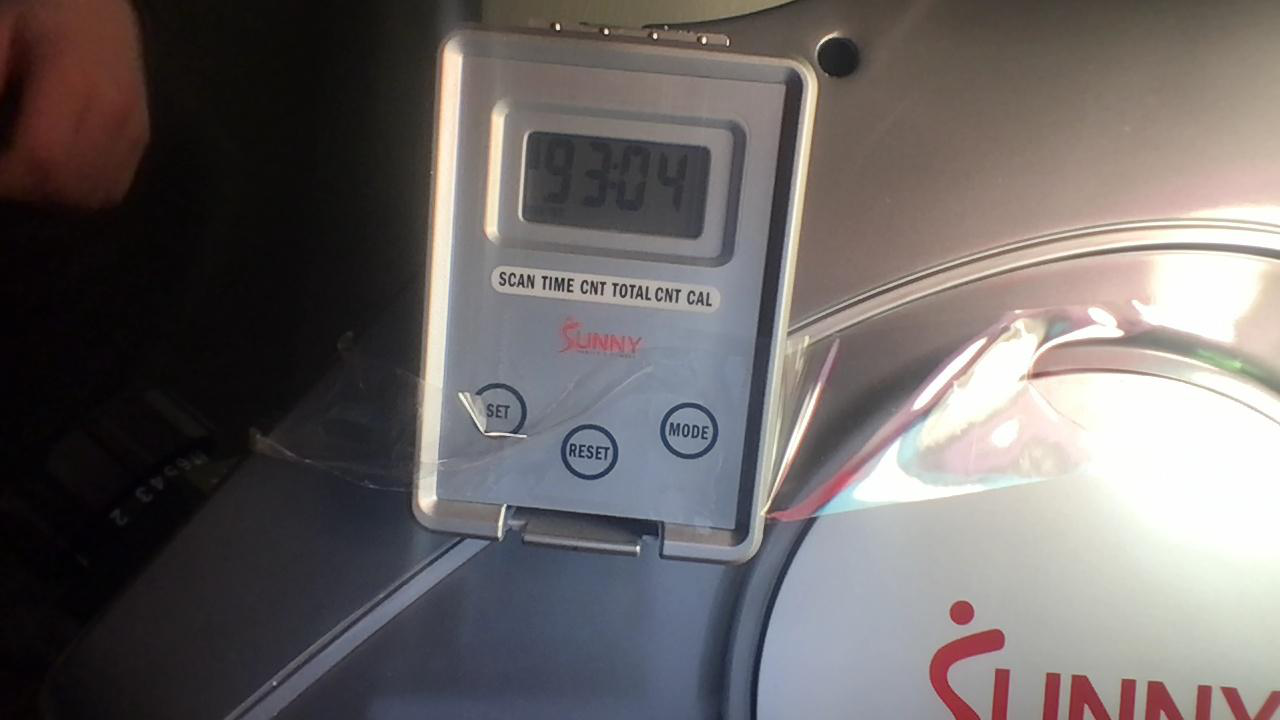

index 113
yolo: 552 <<< 552
api:  8352


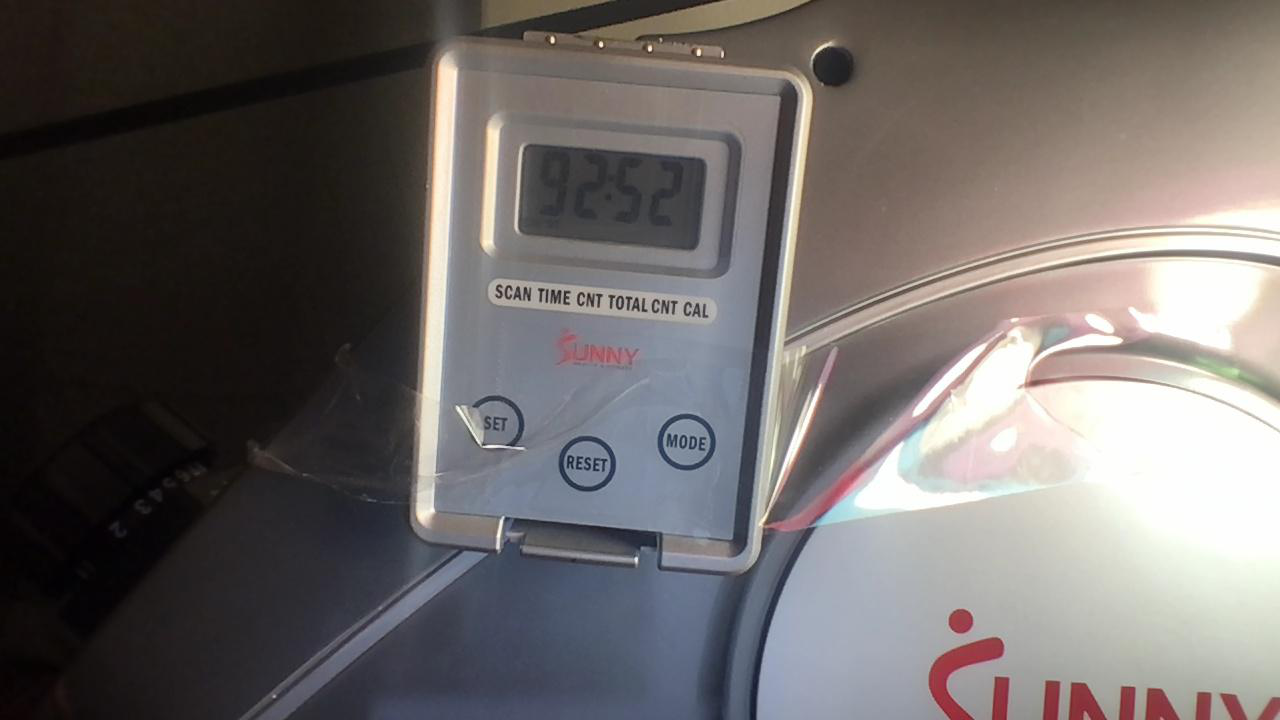

index 138
yolo: 3320 <<< 3320
api:  4320


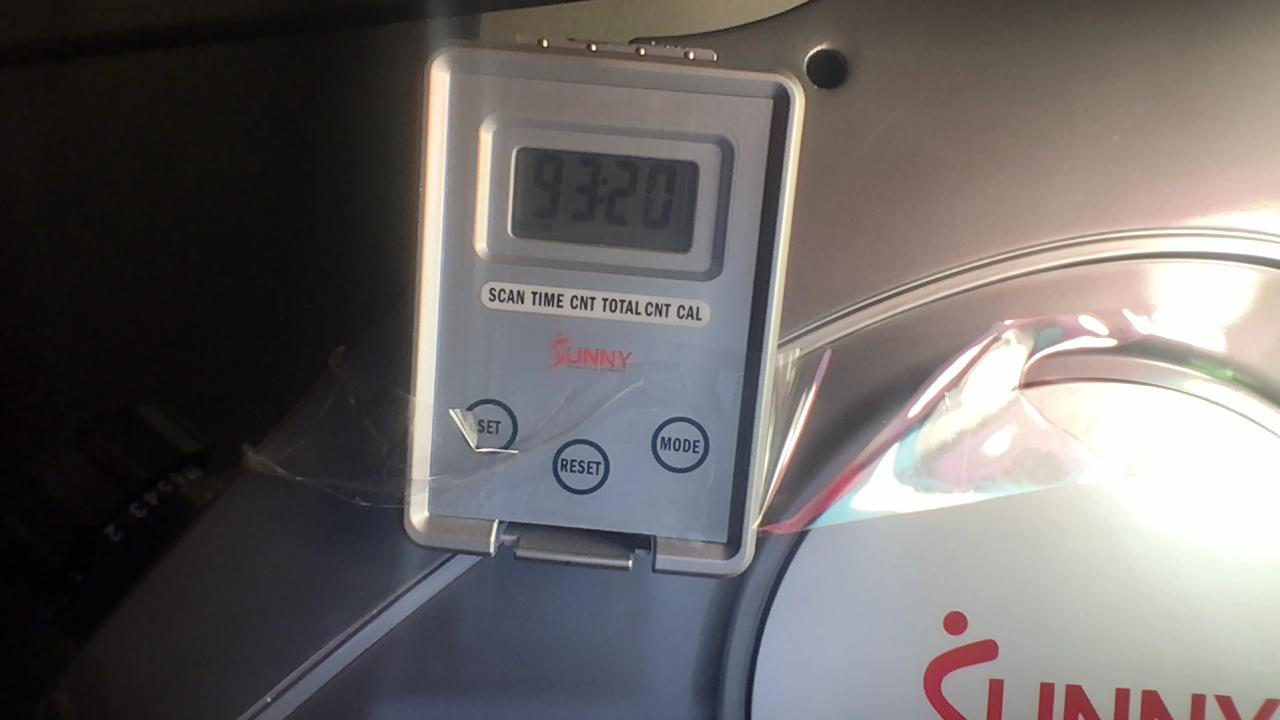

index 120
yolo: 4301 <<< 4301
api:  3301


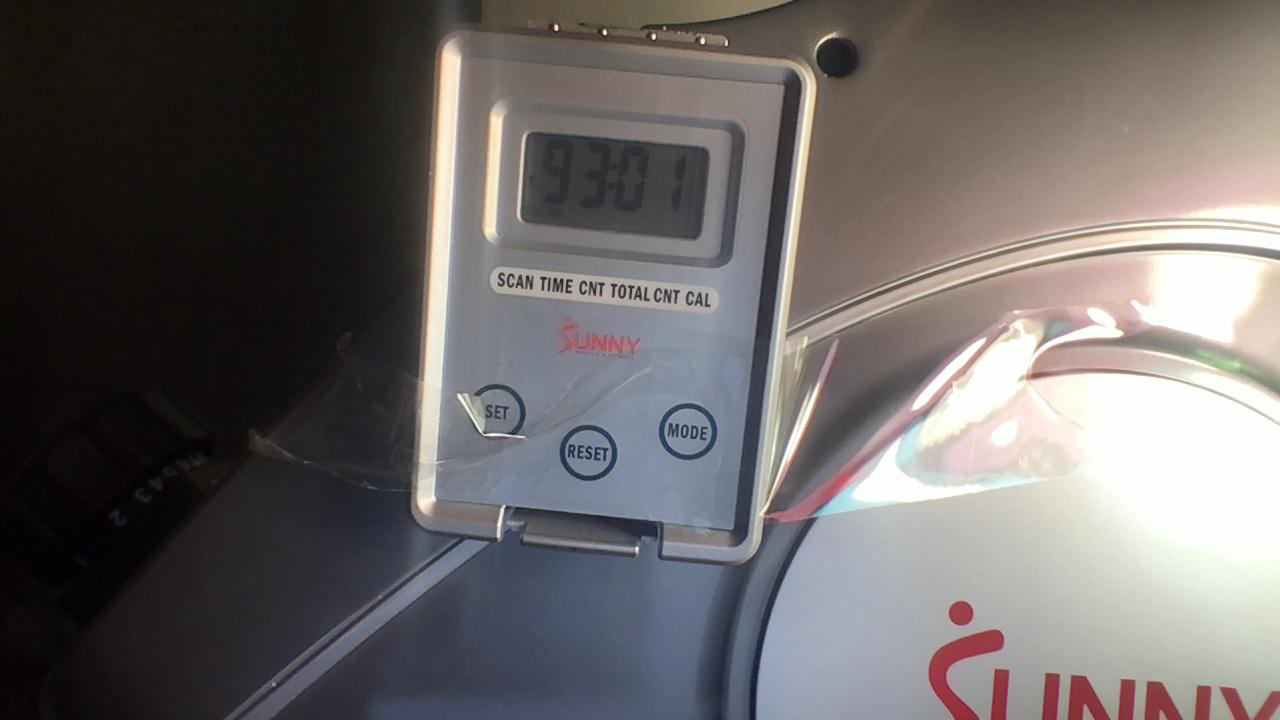

index 190
yolo: 3428 <<< 3428
api:  9428


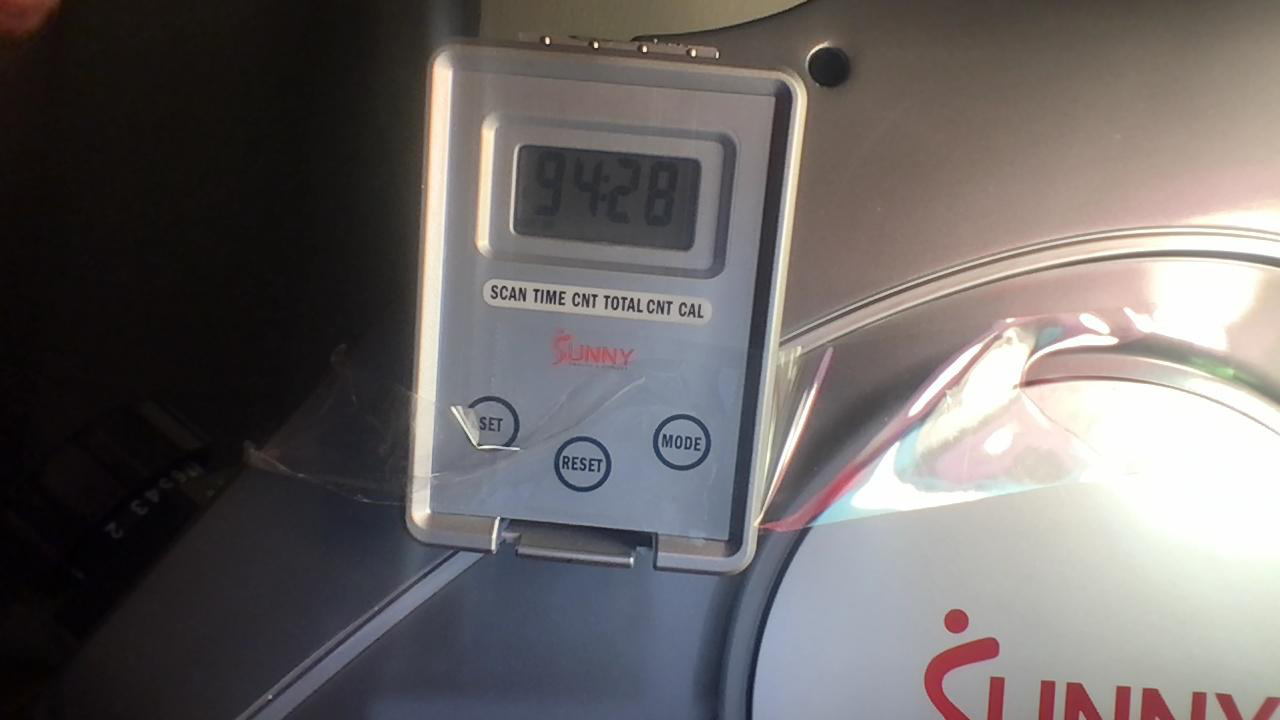

In [ ]:
# iterate through a dataframe and view a sampling of the predictions 
# along with the original

for i,row in df.sample(5).iterrows():
  print("index", i)
  print("yolo:", row["yolo"], "<<<", row["yolo original"])
  if RUN_ROBOFLOW_API == "True":
    print("api: ", row["api"])
  display(PIL.Image.open(postprocess[int(i)]["filename"]))



If the checkbox is unmarked, no file will be created, no file will be downloaded.

In [ ]:
# save the processed data (including YOLOv5 and API output) to JSON
outfilename = "YY-MM-DD save results.json" #@param {type:"string"}
save = False #@param {type:"boolean"}

if save:
  outJSON = {}
  outJSON["processed"] = postprocess
  outJSON["df"] = df.to_dict()
  with open(outfilename, "w") as outfile:
    json.dump(outJSON, outfile)

  # download the JSON for safe-keeping
  from google.colab import files
  files.download(outfilename)